In [78]:
# pip install pycaret

In [ ]:
# pip install xgboost

In [ ]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret.nlp as pycnlp
from datetime import date
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

In [2]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

## 0. Data Exploration and Feature Engineering

In [23]:
df = pd.read_csv("data.csv")
data = df[df['CustomerID'].notna()] # generaly, an invoice without a customer is useless.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [24]:
"""
METHOD: drop_immed_cancels.
Drops from the data invoices which were canceled right after they were made,
since these invoices were probaly a mistake (i.e. buying 100 socks instead of 10).
An "immediate cancle" is a pair of invoices which:
    - Happend on the same day.
    - Purchased the same item.
    - The sum of the quantities is zero.
INPUT: data - the DataFrame which holds the data (must contain 'Quantity', 'CustomerID', 'StockCode' and 'InvoiceDate' columns.)
OUTPUT: the new data.
"""
def drop_immed_cancels(data: pd.DataFrame) -> pd.DataFrame:
    # creates new columns for identifying immediate cancels. 
    data["AbsQuantity"] = np.abs(data["Quantity"])
    data["DaysFromToday"] = data["InvoiceDate"].apply(lambda x: (date.today()-x.to_pydatetime().date()).days)
    data = data.drop_duplicates(subset=["AbsQuantity", "DaysFromToday","CustomerID","StockCode"], keep=False)
    return data.drop(["AbsQuantity", "DaysFromToday"], axis=1)

data = drop_immed_cancels(data).reset_index().drop(["index"], axis=1)

Let's explore the "Country" distribution.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, 'United Kingdom'),
  Text(1, 0, 'France'),
  Text(2, 0, 'Australia'),
  Text(3, 0, 'Netherlands'),
  Text(4, 0, 'Germany'),
  Text(5, 0, 'Norway'),
  Text(6, 0, 'EIRE'),
  Text(7, 0, 'Switzerland'),
  Text(8, 0, 'Spain'),
  Text(9, 0, 'Poland'),
  Text(10, 0, 'Portugal'),
  Text(11, 0, 'Italy'),
  Text(12, 0, 'Belgium'),
  Text(13, 0, 'Lithuania'),
  Text(14, 0, 'Japan'),
  Text(15, 0, 'Iceland'),
  Text(16, 0, 'Channel Islands'),
  Text(17, 0, 'Denmark'),
  Text(18, 0, 'Cyprus'),
  Text(19, 0, 'Austria'),
  Text(20, 0, 'Israel'),
  Text(21, 0, 'Finland'),
  Text(22, 0, 'Sweden'),
  Text(23, 0, 'Greece'),
  Text(24, 0, 'Singapore'),
  Text(25, 0, 'Lebanon'),
  Text(26, 0, 'United Arab Emirates'),
  Text(27, 0, 'Saudi Arabia'),
  Text(28, 0, 'Czech Republic'),
  Text(29, 0, 'Canada'),
  Text(30, 0, 'Uns

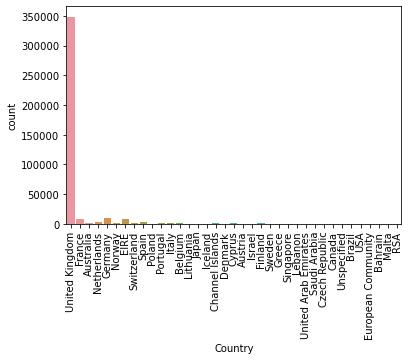

In [5]:
sns.countplot(data=data, x="Country")
plt.xticks(rotation=90)

We can see that the vast majority of the samples were taken from the UK.
We can conclude that:

    1. the "Country" column is meaningless. 
    2. We should focus the research on invoices from the UK, and drop invoices from different countries.

In [25]:
data = data[data["Country"] == "United Kingdom"]
data = data.drop("Country", axis=1)

In [26]:
data = data.reset_index(drop=True)

Let's explore the "Quantity" and "UnitPrice" distributions.

In [8]:
data.describe().drop("CustomerID", axis=1)

,Quantity,UnitPrice
count,348548.000000,348548.000000
mean,11.289033,3.195681
std,49.395582,69.008518
min,-9360.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,1.950000
75%,12.000000,3.750000
max,12540.000000,38970.000000


We can see that "Quantity" and "UnitPrice" have huge max values and STDs, with respect to most of the data.

In [28]:
"""
METHOD: drop_IQR.
Drops invoices from the data based on the IQR of a given column.
The IQR (InterQuartile Range) of data samples is the difference between the lower quartile and the upper quartile.
It is common to interpret samples which are lower than Q1-1.5*IQR or higher than Q3+1.5*IQR as outliers.
INPUT: data - the DataFrame which holds the data.
OUTPUT: the new data.
"""
def drop_IQR(data: pd.DataFrame, column: str) -> pd.DataFrame:
    try:
        Q1 = data.describe()[column]["25%"] # the lower quartile.
        Q3 = data.describe()[column]["75%"] # the upper quartile.
        IQR = Q3-Q1
        return data[data[column].between(Q1-1.5*IQR, Q3+1.5*IQR, inclusive=True)]
    except KeyError:
        print(f"[!] ERROR - data doesn't contain the column {column}.")
        return data
    except Exception as e:
        print(f"[!] ERROR - {e}.")
        return data

data = drop_IQR(data, "Quantity")
data = drop_IQR(data, "UnitPrice")
data = data.reset_index(drop=True)

In [80]:
data.describe().drop("CustomerID", axis=1)

,Quantity,UnitPrice
count,298622.000000,298622.000000
mean,7.074017,2.200629
std,6.782549,1.552065
min,-13.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,1.650000
75%,12.000000,2.950000
max,27.000000,7.500000


In [31]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0
1,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0
2,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047.0
3,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047.0
4,536367,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,2010-12-01 08:34:00,4.25,13047.0
...,...,...,...,...,...,...,...
298617,581585,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,2011-12-09 12:31:00,0.95,15804.0
298618,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0
298619,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0
298620,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0


We've managed to clean and drop about 45% of the original data!

## 1. Most Popular Recommendation System

In [12]:
"""
METHOD: popular_recommend.
Computes the most popular items in the store and revommand them.
Popularity is calculated based on the last dates the item was bought,
and the log of the quantity which was bought:
    - An item which sold more units is more popular.
    - An item which was bought recently is more popular.
    - Last purchase date affects popularity more than quantity which was bought.
INPUT: data - the DataFrame which holds the data (must contain 'StockCode', 'Quantity' and 'InvoiceDate' columns.)
       LAST_DAYS - how many days back should the algorithm look into?
       TOP_POPULAR - how many results should the algorithm return?
OUTPUT: the TOP_POPULAR most popular items.
"""
def popular_recommend(data:pd.DataFrame, LAST_DAYS:int=7, TOP_POPULAR:int=10) -> pd.DataFrame:
    # prepares the data for evaluation.
    try:
        data = data[['StockCode', 'Quantity', 'InvoiceDate', 'Description']].set_index('StockCode')
        # computes the days-distance between "today" and the invoice day.
        data['InvoiceDate'] = data['InvoiceDate'].apply(lambda x: (date.today()-x.to_pydatetime().date()).days)
        # if there's not enough invoices in the last LAST_DAYS, expend the domain of the search.
        while data[data['InvoiceDate']<=LAST_DAYS].shape[0]<TOP_POPULAR and LAST_DAYS<=data['InvoiceDate'].max():
            LAST_DAYS += 1
        data = data[data['InvoiceDate']<=LAST_DAYS]
        TOP_POPULAR = min(TOP_POPULAR, data.shape[0])
    # if some columns are missing.
    except KeyError:
        print("[!] ERROR - couldn't find the key StockCode, Quantity or InvoiceDate.")
        return None
    except Exception as e:
        print(e)
        return None
    
    quan_item = data.groupby("StockCode").sum()["Quantity"] 
    date_item = data.groupby("StockCode").sum()["InvoiceDate"] + 1
    # computes "Popularity Rate" for each item.
    # the log of the quantities is taken in order to make the time aspect more meaningful.
    data["Popularity"] =(np.log(np.abs(quan_item)+0.00001)*np.sign(quan_item))/(date_item)
    data["Popularity"].fillna(0)
    return data.nlargest(TOP_POPULAR, "Popularity")

In [13]:
# Example
globalRecomm = popular_recommend(data.copy())
globalRecomm

Wall time: 7.68 s


,Quantity,InvoiceDate,Popularity
StockCode,,,
16169E,25,3757,0.000857
22985,25,3757,0.000857
22704,25,3757,0.000857
84692,25,3757,0.000857
22216,24,3757,0.000846
22955,24,3757,0.000846
84947,24,3757,0.000846
22072,24,3757,0.000846
22123,24,3757,0.000846


## 2. Similar Items Recommendation System

In [32]:
# using pycaret.nlp for preparing the descriptions for analyzing.
# takes 10-15 minutes.
setup = pycnlp.setup(data=data, target="Description", custom_stopwords=list(set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))))

Description,Value
session_id,3694
Documents,298622
Vocab Size,1039
Custom Stopwords,True


Wall time: 11min 52s


After examining different model types (HDP, LSI etc.) and different number of topics,
it turned out that the best performances were given when choosing an LDA (Latent Dirichlet Allocation) with three topics.

**NOTE**: it is possible to use pycaret.nlp "tune_model" method for choosing the best number of topics,
but this method is quite slow and heavy, and might not be able to run properly.

In [33]:
# takes 2-5 minutes.
LDAModel = pycnlp.create_model(model='lda', num_topics=3, multi_core=True)

Wall time: 2min 34s


In [34]:
# takes 2-5 minutes.
LDAResult = pycnlp.assign_model(LDAModel)

Wall time: 3min 31s


**NOTE**: the following method takes **a lot** of time to run.

In [35]:
"""
METHOD: split_equal_probas.
Randomly splits items with equal probabilities to belong to each topic, 
in order to balance the data.
INPUT: data - the DataFrame which holds the data.
OUTPUT: the new data.
"""
"""
def split_equal_probas(data: pd.DataFrame) -> pd.DataFrame:
    for i in range(data.shape[0]):
        # if the item has equal probabilities to belong to each topic.
        if(data.loc[i, "Perc_Dominant_Topic"]==round(1/len(data["Dominant_Topic"].unique()), 2)):
            # choose a random topic.
            data.loc[i, "Dominant_Topic"] = random.choice(data["Dominant_Topic"].unique())
    return data
             
%time LDAResult = split_equal_probas(LDAResult)
"""

'\ndef split_equal_probas(data: pd.DataFrame) -> pd.DataFrame:\n    for i in range(data.shape[0]):\n        # if the item has equal probabilities to belong to each topic.\n        if(data.loc[i, "Perc_Dominant_Topic"]==round(1/len(data["Dominant_Topic"].unique()), 2)):\n            # choose a random topic.\n            data.loc[i, "Dominant_Topic"] = random.choice(data["Dominant_Topic"].unique())\n    return data\n             \n%time LDAResult = split_equal_probas(LDAResult)\n'

<AxesSubplot:xlabel='Dominant_Topic', ylabel='count'>

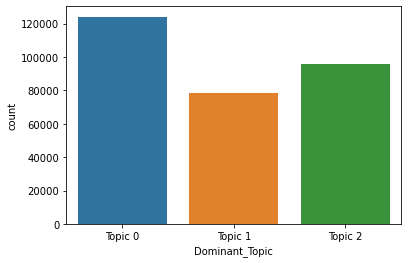

In [36]:
sns.countplot(data=LDAResult, x="Dominant_Topic")

In [76]:
# models to try and train, with hyperparameters tuning options.
models = {'SVC':[SVC(gamma='auto'), {
              'kernel':['rbf', 'poly'],
              'degree':[1, 2, 3],
              'C':[0.01, 0.1, 0.5, 1]}], 
          'DECISION-TREE':[DecisionTreeClassifier(), {
              'criterion':['gini', 'entropy'],
              'min_samples_split':[1,2,3],
              'splitter':['best', 'random']}],
          'K-NEIGHBORS':[KNeighborsClassifier(), {
              'n_neighbors':[3,4,5,6,7],
              'weights':['uniform', 'distance']}],
          'LOGISTIC-REGRESSION':[LogisticRegression(max_iter=200), {
              'penalty':['l1', 'l2', 'elasticnet'],
              'C':[0.01, 0.05, 0.1, 0.25, 0.5, 1]}],
          'ADA-BOOST':[AdaBoostClassifier(), {
              'n_estimators':[40, 50, 60, 70],
              'learning_rate':[0.1, 0.2, 0.3]}],
          'XGBOOST':[XGBClassifier(verbosity=0), {
              'n_estimators':[40, 50, 60, 70],
              'learning_rate':[0.1, 0.2, 0.3],
              'max_depth':[3,4,5],
              'gamma':[0, 5, 10]}]}

# the scores of each model.
scores = {}

In [59]:
# performs TF-IDF vectorization of the data.
tfidfVector = TfidfVectorizer()
X, Y = LDAResult["Description"], LDAResult["Dominant_Topic"]
X = tfidfVector.fit_transform(X)
X

<298622x1039 sparse matrix of type '<class 'numpy.float64'>'
	with 689604 stored elements in Compressed Sparse Row format>

The next cell selects only about 7% of the data to train and perform CV on, since using more than that takes a lot of time.
Training 10000 rows takes 10-15 minutes, while training 20000 rows takes 30-40 minutes.

In [60]:
X = X[0:20000, :]
Y = Y[0:20000]
X

<20000x1039 sparse matrix of type '<class 'numpy.float64'>'
	with 46117 stored elements in Compressed Sparse Row format>

In [61]:
"""
METHOD: train_models.
Trains different models of the dataset (with CV) with different hyperparameters,
and calculates their performance using 'f1-weighted' score.
INPUT: X - the dataset.
       Y - the labels set.
       models - a dictionary with the models' names, base-model and parameter-grid.
       scores - a dictionary to store the f1-weighted scores.
OUTPUT: the updated "scores" dictionary.
"""
def train_models(X: pd.DataFrame, Y: pd.DataFrame, models: dict, scores: dict) -> pd.DataFrame:
    for name, params in models.items():
        print(name)
        grid = GridSearchCV(estimator=params[0], param_grid=params[1], scoring='f1_weighted')
        try:
            gridResults = grid.fit(X, Y) # fitting and hyperparameters tuning for each model.
        except Exception as e:
            print(f"[!] ERROR ({name}) - {e}")
            continue
        # stores the f1-weighted score of each model.
        scores[name] = [gridResults.best_estimator_, gridResults.best_score_]
    return scores

%time scores = train_models(X, Y, models, scores)

SVC
DECISION-TREE
K-NEIGHBORS
LOGISTIC-REGRESSION
ADA-BOOST
XGBOOST
Wall time: 36min 32s


In [62]:
scores

{'SVC': [SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=1, gamma='auto', kernel='rbf',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  0.2977013384215218],
 'DECISION-TREE': [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='random'),
  0.9928479000065359],
 'K-NEIGHBORS': [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                       weights='distance'),
  0.990392822973

In [63]:
# chooses the best model (according to the f1-weighted score).
bestModel = None
bestScore = 0
for name, model in scores.items():
    if model[1]>bestScore:
        bestScore = model[1]
        bestModel = model[0]

In [64]:
print(bestModel)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')


In [65]:
# a pipline for predicting items.
pipe = Pipeline(steps=[
    ("tfidfVector", TfidfVectorizer()), 
    ("model", bestModel)
])

In [66]:
pipe.fit(data["Description"][0:20000], Y)

Pipeline(memory=None,
         steps=[('tfidfVector',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
          

Let's examine how well the model performs.

In [67]:
LDAResult["Predict"] = pipe.predict(data["Description"])

In [77]:
print(classification_report(LDAResult["Dominant_Topic"], LDAResult["Predict"]))

              precision    recall  f1-score   support

     Topic 0       0.93      0.91      0.92    124108
     Topic 1       0.89      0.86      0.87     78711
     Topic 2       0.89      0.95      0.92     95803

    accuracy                           0.91    298622
   macro avg       0.90      0.90      0.90    298622
weighted avg       0.91      0.91      0.91    298622



<AxesSubplot:xlabel='Dominant_Topic', ylabel='count'>

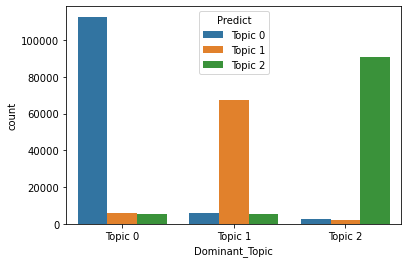

In [70]:
sns.countplot(data=LDAResult, x="Dominant_Topic", hue="Predict")

Despite training only 7% of the data, the model performs quite well!

In [52]:
"""
METHOD: similar_items_by_item.
Returns a DataFrame with items which are similar to a given one, according to the topic modeling which was performed.
INPUT: item - the given item.
       data - the DataFrame which holds the data.
       pipe - a pipeline to perform classification.
OUTPUT - a DataFrame with items which are similar to "item".
"""
def similar_items_by_item(item: str, data: pd.DataFrame, pipe: Pipeline) -> pd.DataFrame:
    # predicts the item's topic.
    topic = pipe.predict([item])[0] 
    print(topic)
    # returns other popular items of that topic.
    return popular_recommend(data[data["Dominant_Topic"]==topic])

In [ ]:
"""
METHOD: similar_items_by_user.
Returns a DataFrame with items which are similar to a given user's most popular purchases.
INPUT: user - the given user's ID.
       data - the DataFrame which holds the data.
       pipe - a pipeline to perform classification.
OUTPUT - a DataFrame with items which are similar to "user"'s most popular purchases
"""
def similar_items_by_user(user: float, data: pd.DataFrame, pipe: Pipeline) -> pd.DataFrame:
    user_popular = popular_recommend(data[data["CustomerID"]==user])
    return similar_items_by_item(user_popular.index[0], data, pipe)

In [57]:
# example.
similar_items_by_item("airline red set", LDAResult, pipe)

Topic 1


,Quantity,InvoiceDate,Popularity
StockCode,,,
22985,25,3758,0.000856
22704,25,3758,0.000856
84692,25,3758,0.000856
22072,24,3758,0.000845
22123,24,3758,0.000845
23302,24,3758,0.000845
22865,24,3758,0.000845
22314,24,3758,0.000845
22190,24,3758,0.000845


In [ ]:
# example.
similar_items_by_user(17841.0, LDAResult, pipe)